In [1]:
import os,pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras import models,layers
from IPython import display

# reproducing experiment with seed
sz = 57
tf.random.set_seed(sz)
np.random.seed(sz)

In [2]:
audios = 'audios'
path = pathlib.Path(audios)

print(path.exists())

True


In [3]:
word = np.array(tf.io.gfile.listdir(str(path)))
print(word)

['environment' 'stop' 'up' 'yes']


Getting audio from directory

In [16]:
trainData,valData = tf.keras.utils.audio_dataset_from_directory(
    directory=path,
    batch_size=64,
    validation_split=.2,
    seed=0,
    output_sequence_length=16000,
    subset='both',
)
print(trainData.class_names)
commandName = np.array(trainData.class_names)

Found 3903 files belonging to 4 classes.
Using 3123 files for training.
Using 780 files for validation.
['environment', 'stop', 'up', 'yes']


each trainData element has a shape of (batch, samples, channel)

SO next we are removing channel axis because all audios are mono(1 channel) not stereo(2 channel)

In [17]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

trainData = trainData.map(squeeze, tf.data.AUTOTUNE)
valData = valData.map(squeeze, tf.data.AUTOTUNE)

Splitting the validation dataset to get a test dataset using Dataset.shard Tensorflow function

In [18]:
testData = valData.shard(num_shards=2,index=0)
valData = valData.shard(num_shards=2,index=1)

In [19]:
# testing out one file

for aud,labelz in trainData.take(1):
    print(aud.shape)
    print(labelz.shape)

(64, 16000)
(64,)


In [21]:
commandName[[0,3,1]]

array(['environment', 'yes', 'stop'], dtype='<U11')

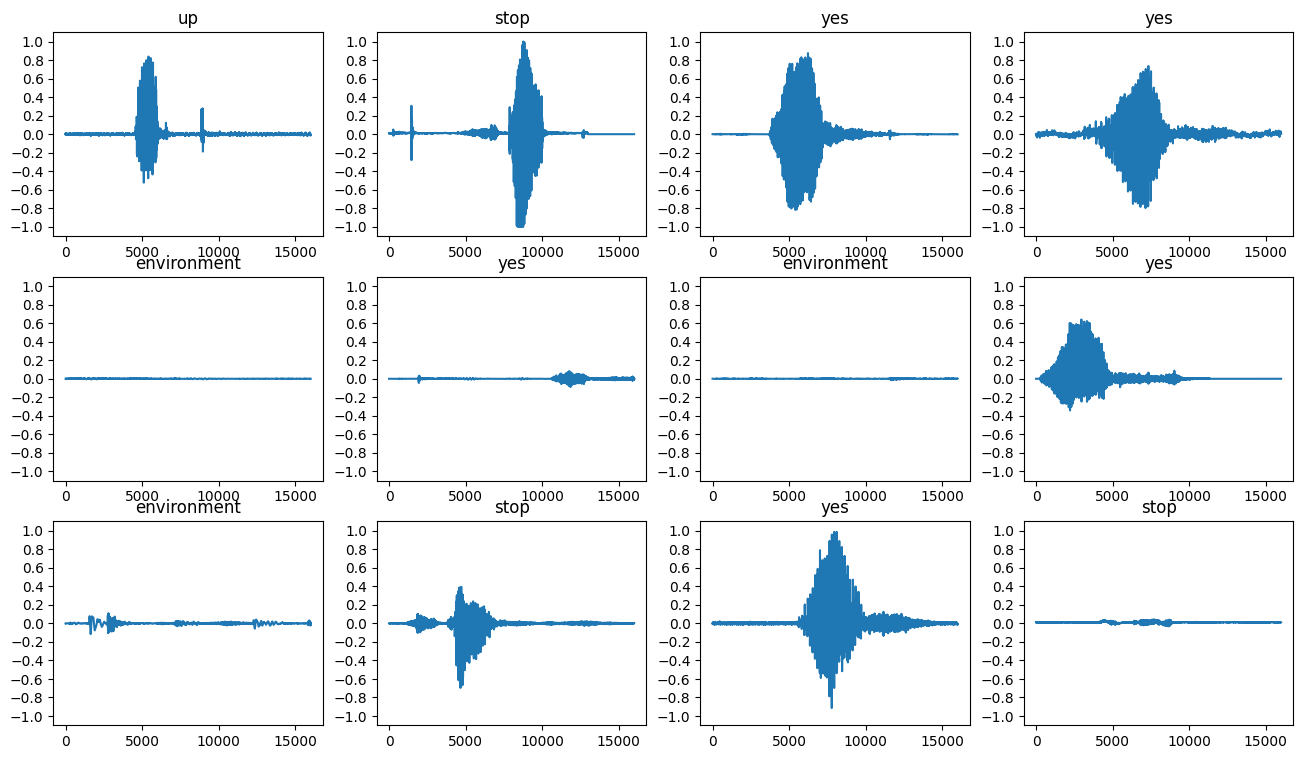

In [22]:
rows = 3
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(aud[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.set_title(commandName[labelz[i]])
  ax.set_ylim([-1.1,1.1])

plt.show()

changing waveform to spectogram so i can feed to the neural network.

here we use **tf.signal.stft**

In [23]:
def get_spec(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used as image-like input data with convolution layers 
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [24]:
for i in range(3):
  label = commandName[labelz[i]]
  waveform = aud[i]
  spectrogram = get_spec(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [25]:
def plot_spec(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

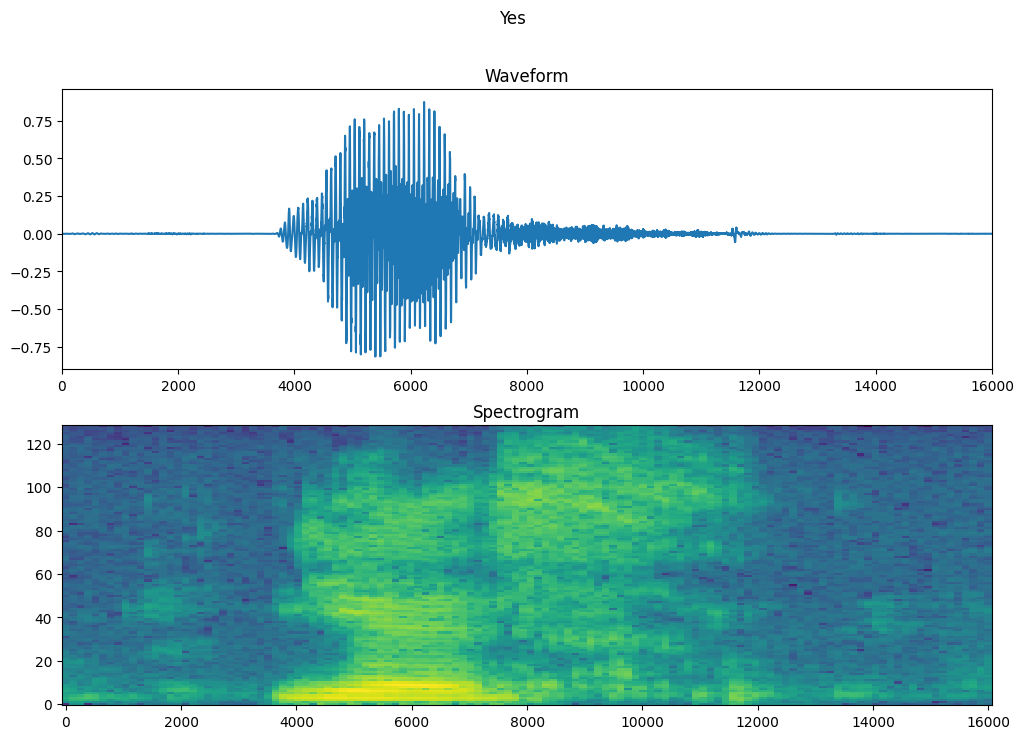

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spec(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [27]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spec(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
trainDataSp = make_spec_ds(trainData)
valDataSp = make_spec_ds(valData)
testDataSp = make_spec_ds(testData)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [29]:
for tsp,lsp in trainDataSp.take(1):
    break

0 0
0 1
0 2
1 0
1 1
1 2


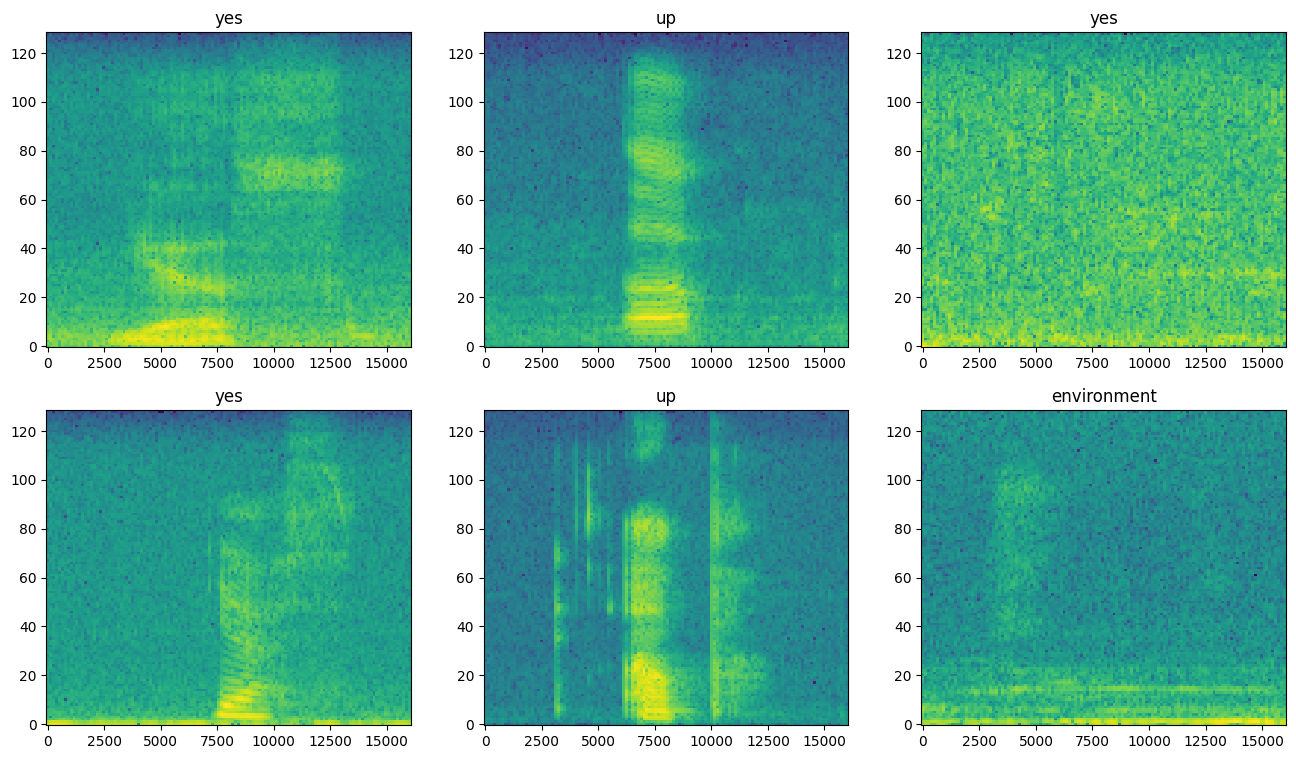

In [30]:
rows = 2
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  print(r, c)
  ax = axes[r][c]
  plot_spec(tsp[i].numpy(),ax)
  ax.set_title(commandName[lsp[i]])

plt.show()

building model

In [31]:
trainDataSp = trainDataSp.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
valDataSp = valDataSp.cache().prefetch(tf.data.AUTOTUNE)
testDataSp = testDataSp.cache().prefetch(tf.data.AUTOTUNE)

In [32]:
input_shape = tsp.shape[1:]

normLyr = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
normLyr.adapt(data=trainDataSp.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    normLyr,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(commandName)),
])

In [33]:
print("input:", input_shape)
model.summary(show_trainable=True)

input: (124, 129, 1)
Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 resizing (Resizing)         (None, 32, 32, 1)         0         Y          
                                                                            
 normalization (Normalizatio  (None, 32, 32, 1)        3         Y          
 n)                                                                         
                                                                            
 conv2d (Conv2D)             (None, 30, 30, 32)        320       Y          
                                                                            
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     Y          
                                                                            
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         Y          
 )                                 

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [35]:
EPOCHS = 10
history = model.fit(
    trainDataSp,
    validation_data=valDataSp,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
49/49 [==============================] - 74s 1s/step - loss: 0.8657 - accuracy: 0.7038 - val_loss: 0.5753 - val_accuracy: 0.8177
Epoch 2/10
49/49 [==============================] - 45s 911ms/step - loss: 0.5335 - accuracy: 0.8252 - val_loss: 0.4431 - val_accuracy: 0.8802
Epoch 3/10
49/49 [==============================] - 47s 956ms/step - loss: 0.4131 - accuracy: 0.8684 - val_loss: 0.3840 - val_accuracy: 0.8854
Epoch 4/10
49/49 [==============================] - 53s 1s/step - loss: 0.3628 - accuracy: 0.8898 - val_loss: 0.3295 - val_accuracy: 0.9193
Epoch 5/10
49/49 [==============================] - 52s 1s/step - loss: 0.2963 - accuracy: 0.9068 - val_loss: 0.3026 - val_accuracy: 0.9219
Epoch 6/10
49/49 [==============================] - 51s 1s/step - loss: 0.2619 - accuracy: 0.9209 - val_loss: 0.2946 - val_accuracy: 0.9297
Epoch 7/10
49/49 [==============================] - 48s 963ms/step - loss: 0.2339 - accuracy: 0.9235 - val_loss: 0.2921 - val_accuracy: 0.9297
Epoch 8/10


Text(0, 0.5, 'Accuracy [%]')

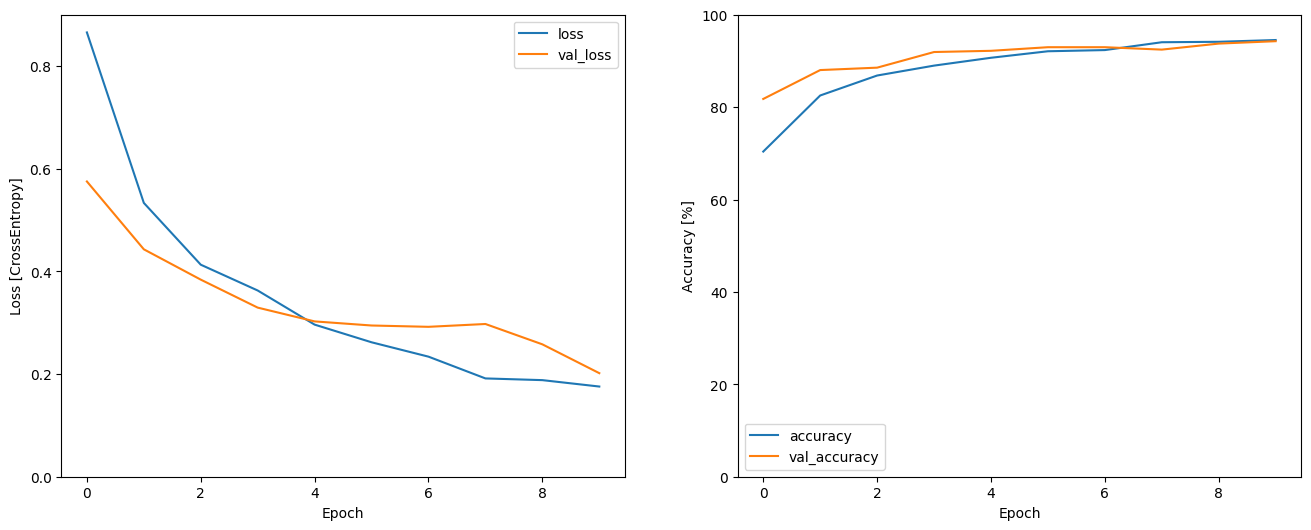

In [36]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [37]:
model.evaluate(testDataSp, return_dict=True)

7/7 [==============================] - 5s 509ms/step - loss: 0.2772 - accuracy: 0.9217


{'loss': 0.27724650502204895, 'accuracy': 0.9217171669006348}

checking the model's learning using a confusion matrix

In [38]:
y_pred = model.predict(testDataSp)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(testDataSp.map(lambda s,lab: lab)), axis=0)

7/7 [==============================] - 4s 266ms/step


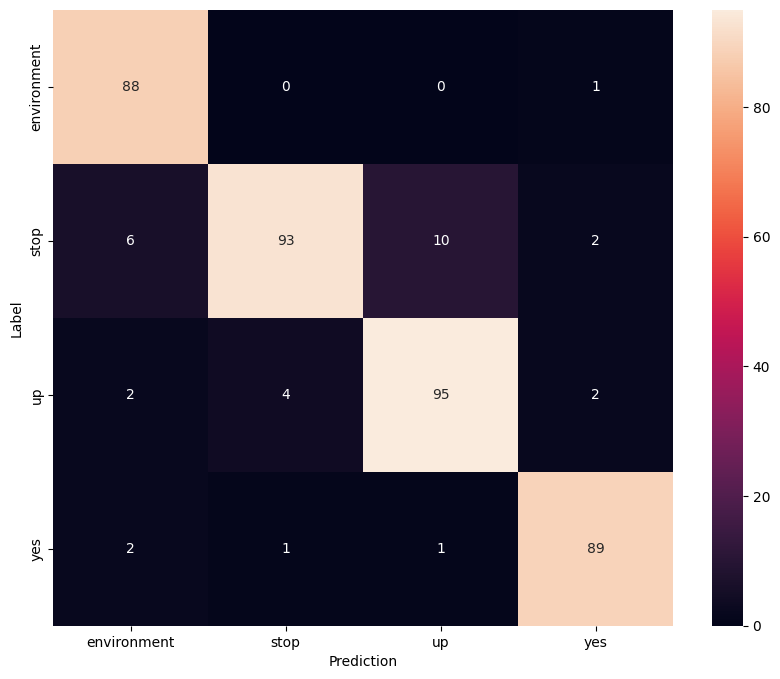

In [40]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commandName,
            yticklabels=commandName,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

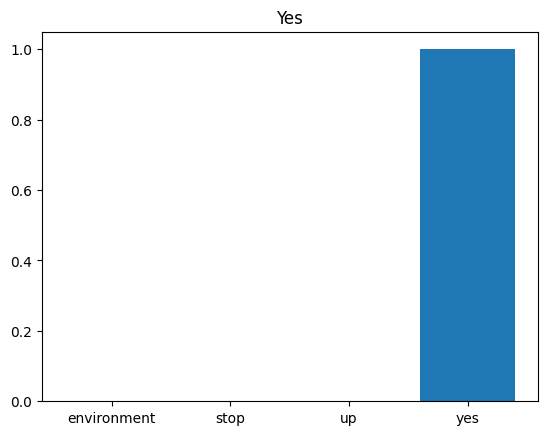

In [44]:
x = 'test/0ac15fe9_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spec(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['environment','stop','up','yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Yes')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [45]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
     
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spec(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(commandName, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [47]:
final = ExportModel(model)
final(tf.constant(str('test/0ac15fe9_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[  1.2007898,  -2.3074038, -11.422521 ,  16.97857  ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'yes'], dtype=object)>}

In [48]:
tf.saved_model.save(final,"SnipAI")

INFO:tensorflow:Assets written to: SnipAI\assets


INFO:tensorflow:Assets written to: SnipAI\assets


In [49]:
o = tf.saved_model.load("SnipAI")
o(waveform[tf.newaxis,:])

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>,
 'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[  1.2007898,  -2.3074038, -11.422521 ,  16.97857  ]],
       dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'yes'], dtype=object)>}

now using it in another notebook